***

# Geothermal Well Test Analysis with Python
### Notebook 3: Determining well capacicity as injectivity index
#### Irene Wallis and Katie McLean 
#### Software Underground, Transform 2021

***

# 7. Injectivity index

The injectivity index is a measure of the amount of fluid the well can accept during injection. Specifically, it is the change in mass rate (t/hr) per change in pressure (bar), hence it has the units t/hr/bar. 

If the well is destined to be used as an injection well, then the injectivity is a direct measure of the future well performance (though it must be corrected for different injectate temperatures). 

If the well is destined to be used as a production well then the injectivity is used to give an indication of future productivity. Productivity index also has the units t/h/bar though it refers to the flow rate out of the well during production, divided by the pressure drop (pressure drawdown) downhole during production. 
 
This notebook gives a workflow to: 
- Import and check data 
- Select the stable pressure values to use for each flow rate
- Create the flow rate vs stable pressure plot (t/h vs bar)
- Use linear regression to find the slope (t/h/bar)

***

### Google Colab Setup

If you are using Google Colab to run this notebook, we assume you have already followed the Google Colab setup steps outlined [here](https://github.com/ICWallis/T21-Tutoral-WellTestAnalysis).

Because we are importing data, we need to "mount your Google Drive", which is where we tell this notebook to look for the data files. You will need to mount the Google Drive into each notebook.  

1. Run the cell below. If you are not in Google Colab, running the cell below will just return an error that says "No module named 'google'"

2. Follow the link generated by running this code. That link will ask you to sign in to your google account (use the one where you have saved these tutorial materials in) and to allow this notebook access to your google drive. 

3. Completing step 2 above will generate a code. Copy this code, paste below where it says "Enter your authorization code:", and press ENTER. 

Congratulations, this notebook can now import data!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

***

# 8. Import, munge and check data

## 8.1 Use bespoke functions to import and munge data

The data munging process in 1-overview.ipynb has been turned into bespoke functions located in the functions.py file. We import and use that set of functions in the same way as any other module.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import interactive, Layout, FloatSlider
from utilities import* # functions in the utilities.py file

The cell below will take a little while to run because it includes all steps required to import and munge the data (i.e., everything we did in notebook 1).

In [ ]:
flowrate = read_flowrate(r'Data-FlowRate.xlsx')
pts = read_pts(r'Data-PTS.xlsx')

We use surface pump flow rate and downhole pressure together for our analysis, so we append flow rate to our pts dataframe to make the method simpler. This is done using the append_flowrate_to_pts function from utilities.py

In [ ]:
pts = append_flowrate_to_pts(flowrate, pts)

## 8.2 Import stable temperature/pressure data for comparison

After drilling and injection testing, geothermal wells heat up over time. 
So for comparison, we have provided a temperature log acquired when the well had reached its stable condition.


In [ ]:
heating_37days = pd.read_csv('Data-Temp-Heating37days.csv')

heating_37days['pressure_bara'] = heating_37days.pres_barg - 1

heating_37days.head(2)


## 8.3 Check the data

It is good practice to check your data after import. 

You can use the Pandas methods listed in Section 2.1.1 (1-intro-and-data.ipynb) to check your data. 

In [ ]:
pts.head(2)

In [ ]:
flowrate.head(2)

In [ ]:
heating_37days.head(2)

We made the plot below to check that we have imported what we expected to import. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24,8),sharey=True)

ax1.scatter(pts.pressure_bara, pts.depth_m, c = pts.timestamp, s = 5, linewidths = 0)

ax1.plot(heating_37days.pressure_bara, heating_37days.depth_m, c = 'k', label = 'Heating 37 days')

ax1.legend()

ax2.scatter(pts.datetime, pts.depth_m, c = pts.timestamp, s = 5, linewidths = 0)

ax3 = ax2.twinx()
ax3.plot(flowrate.datetime, flowrate.flow_tph, 
    c='k', linestyle = '-', linewidth = 3, alpha = 0.3, 
    label='Surface pump flowrate')

ax1.set_ylim(1000,0)  # 940,400 
ax1.set_xlim(0,55)     # 20,500

ax1.set_xlabel('Pressure [bara]')
ax1.set_ylabel('Depth [m]')

ax2.set_xlabel('Time [hh:mm]')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax3.set_ylabel('Flowrate [t/hr]')

for ax in [ax1, ax2]:
    ax.grid()

***

# 9. Pressure inside geothermal wells

Note that the pressure measured inside the well does not equate to the pressure in the reservoir. It varies depending on the liquid level and the density (temperature & phase) of the fluid inside the well. As the well heats up after drilling, pressure profiles will appear to pivot around a single point. That pressure of the pivot point equates to the reservoir pressure at the depth of pivoting.  

***

# 10. Select the most stable pressure values for each flow rate 

## 10.1 Interactive plot with ipywidgets

Use the interactive plot to select the times within the completion test program when the pressure down-hole is most likely to be stable for a given flow rate. 

The most stable pressure is usually just after the pts tool returned to the programmed hanging depth that was for pressure transient after the well passes are complete and before the pump rate is changed. 

In [ ]:

min_timestamp = pts.timestamp.iloc[0]
max_timestamp = pts.timestamp.iloc[-1]

def subselect_plot(first_value, second_value, third_value):
    f,ax1 = plt.subplots(1,1, figsize = (20,6))
    ax1.plot(pts.timestamp, pts.depth_m, c = 'k', label = 'PTS tool depth')
    ax2 = ax1.twinx()
    ax2.plot(flowrate.timestamp, flowrate.flow_tph, c='k', linestyle = ':', label='Surface pump flowrate')
    ymin = pts.depth_m.min()
    ymax = pts.depth_m.max() + 100
    ax1.vlines(first_value, ymin, ymax, color='tab:green')
    ax1.vlines(second_value, ymin, ymax, color='tab:orange')
    ax1.vlines(third_value, ymin, ymax, color='tab:red')
    ax1.set_ylim(pts.depth_m.max() + 100, 0)

result = interactive(subselect_plot,
         
         first_value = FloatSlider
         (
             value = (max_timestamp - min_timestamp)/6 + min_timestamp,
             description = '1st value',
             min = min_timestamp, 
             max = max_timestamp, 
             step = 10, 
             continuous_update=False,
             layout = Layout(width='80%'),
             ),
          
          second_value = FloatSlider
          (
             value = (max_timestamp - min_timestamp)/4 + min_timestamp, 
             description = '2nd value',
             min = min_timestamp, 
             max = max_timestamp, 
             step = 10, 
             continuous_update=False,
             layout = Layout(width='80%')
             ),

          third_value = FloatSlider
          (
             value = (max_timestamp - min_timestamp)/2 + min_timestamp, 
             description = '3rd value',
             min = min_timestamp, 
             max = max_timestamp, 
             step = 10, 
             continuous_update=False,
             layout = Layout(width='80%')
             )
)

display(result);


## 10.2 Call results from the interactive plot

After you place the 1st (green), 2nd (orange), and 3rd (red) line locations, run the cell below to call the results. 

In [ ]:
# extract pressure and flow rate at the marked points
print(
    '1st value =',result.children[0].value, ' which is', datetime.fromtimestamp(result.children[0].value), 
    '\n 2nd value =', result.children[1].value, ' which is', datetime.fromtimestamp(result.children[1].value),
    '\n 3rd value =', result.children[2].value, ' which is', datetime.fromtimestamp(result.children[2].value),
    )


## 10.3 Store analysis

Because result.children will change each time you move the sliders in the plot above or re-run this Jupyter Notebook, we copy-paste our selection below. This records your choice and will be the values you do the rest of the interpretation with. 

#### Our selected data

> 1st value = 1607635724.448  which is 2020-12-11 10:28:44.448000 

> 2nd value = 1607644304.448  which is 2020-12-11 12:51:44.448000 
 
> 3rd value = 1607650704.448  which is 2020-12-11 14:38:24.448000 
 
The third value was selected before the tool made passes because the pumps were shut off so quickly 
that it is difficult to reliably pick the value after the tool passes at this plot scale. 

If we were concerned that the pressure was not stable before the logging passes, 
we could take the time to adjust the scale of our plot and pick the correct location.

In [ ]:
first_timestamp = 1607635724.448
second_timestamp = 1607644304.448
third_timestamp = 1607650704.448

***

# 11. Generate an array of stable pressure and flow rate

Recall that we used the append_flowrate_to_pts function from our utilities.py in Section 8.1 above to append surface pump flow rate to our pts dataframe.

## 11.1 Make new dataframes containing the pts log values at our timestamps

Making our new dataframes is a two-step process:
1. Find the index value where the timestamp is either an exact match to the value we pass in or is the nearest neighbour above and below
2. Make new dataframes using the .iloc method and the timestamp returned by step 1 (i.e., the find_index function)

The find_index function is in utilities.py

In [ ]:
first_pts = pts.iloc[find_index(first_timestamp, pts, 'timestamp')]
second_pts = pts.iloc[find_index(second_timestamp, pts, 'timestamp')]
third_pts = pts.iloc[find_index(third_timestamp, pts, 'timestamp')]

In [ ]:
first_pts

In [ ]:
second_pts

In [ ]:
third_pts

## 11.2 Make pressure and flow rate arrays

Now we either use the exact match value or the mean of the two neighbouring values to make an array of pressure and flow rate that we can use in our injectivity index analysis.

In [ ]:
# make array of mean pressure values

import numpy as np

list = []
for df in [first_pts, second_pts, third_pts]:
    mean_pressure = df['pressure_bara'].mean()
    list.append(mean_pressure)
pressure_array = np.array(list)

print('pressure data =', pressure_array)
print('object type =', type(pressure_array))


In [ ]:
# make array of mean flowrate values

list = []
for df in [first_pts, second_pts, third_pts]:
    mean_flowrate = df['interpolated_flow_tph'].mean()
    list.append(mean_flowrate)
flowrate_array = np.array(list)

print('flowrate data =', flowrate_array)
print('object type =', type(flowrate_array))

***

# 12. Generate a linear regression to find injectivity index

The injectivity is the change in mass rate (t/hr) per change in pressure (bar) that the well will accept. 

If there is nothing unusual going on downhole, then we can find this with simple linear regression. There are many cases where a single linear model is not the best approach, such as where changes in pressure or thermal conditions in the well change the permeability. In these cases, a two-slope approach may be better.

## 12.1 Make the linear model

There are many ways to do a simple linear regression. We selected the stats.linregress method from Scipy because it is relatively simple to use. It's also fast because it is tooled specifically for our two-variable use case. The stats.linregress method returns the slope, intersect and R value that we need for our analysis. 

In [ ]:
from scipy import stats

linear_model = stats.linregress(pressure_array, flowrate_array) 

linear_model

In [ ]:
# Define some sensibly named objects for reuse below

slope = linear_model[0]
intercept = linear_model[1]
rvalue = linear_model[2]

In [ ]:
# Print a nicely formatted string describing of our model

print("The linear model for our data is y = {:.5} + {:.5} * pressure"
      .format(intercept, slope))

## 12.2 Plot the results

In [ ]:
f,ax = plt.subplots(1,1,figsize=(6,4))

ax.scatter(pressure_array, flowrate_array, 
           s=100, c='k', label = 'Data')

ax.plot(pressure_array, # x values
    slope * pressure_array + intercept, # use the model to generate y values
    color='tab:orange', linestyle='-', linewidth=4, alpha=0.5, label='Linear fit')


ax.set_title("Sample well injectivity index = {:} t/hr.bar".format(round(slope)))

#ax.set_ylim(0,130)
#ax.set_xlim(0,40)

ax.legend()
ax.set_ylabel('Rate [t/hr]')
ax.set_xlabel('Pressure [bara]')  

***

# 13. Interpreting injectivity index

### 13.1 Understanding the scale of injectivity index

Based on data from New Zealand geothermal fields, preeminent reservoir engineer Malcolm Grant determined that injectivity index forms a lognormal distribution with the median well around 20 t/hr.bar (Figure 5).

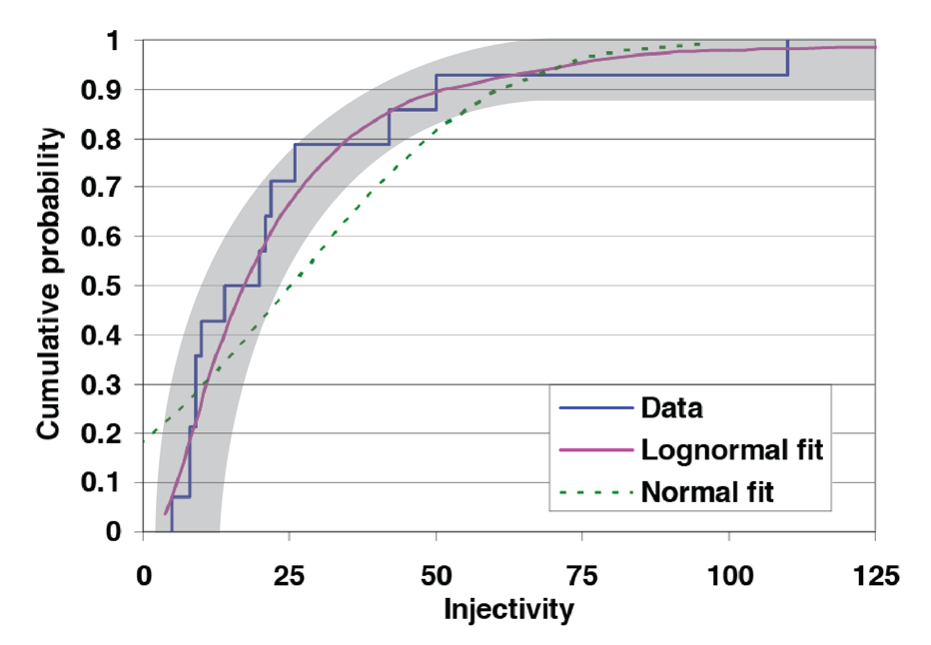

In [2]:
from IPython.display import Image
Image('https://raw.githubusercontent.com/ICWallis/T21-Tutoral-WellTestAnalysis/main/Figures/Figure5.png',width = 500,)

_Figure 5: Like many natural phenomena, geothermal well injectivity has a lognormal distribution. Figure adapted from [Grant (2008)](https://pangea.stanford.edu/ERE/pdf/IGAstandard/SGW/2008/grant.pdf)._

There is no 1:1 relationship between the injectivity index (II) and productivity index (PI) of a geothermal well. Each reservoir is subject to a unique set of conditions that influence the relationship between these indices, such as depth to the liquid level and enthalpy. 

The table below reflects a general rule of thumb used when completion testing wells in a reservoir where the local relationship between II and PI has not already been established.

|Permeability magnitude | II \[t/hr.bar\] |
| --- | --- |
| Very low permeability (near-conductive) | < 1 |
| Poor permeability, usable in special cases | 1 - 5 |
| Likely productive | 5 - 20 |
| Median production well | 20 |
| Reliably economic production for well if T > 250$^{\circ}$C | 20-50 |
| High permeability | 50 - 100 |
| Very high permeability (unusual) | > 100 |


### 13.2 Injectivity index and temperature

The injectivity index is only truly valid for the injectate temperature at which it was measured (i.e., ambient temperature). If you inject at a higher temperature, then the injectivity index would be less. For more information refer to [Siega et al. (2014)](https://www.geothermal-energy.org/pdf/IGAstandard/NZGW/2014/109.Siega.pdf)


# 14. Injectivity in our case study well

With an II of 252 t/hr.bar, our case study well is extremely permeable! Yah! 

***

### Cited references

Grant, M.A. (2008) Decision tree analysis of possible drilling outcomes to optimise drilling decisions: Proceedings, Thrity-Third Workshop of Geothermal Reservoir Engineering. Stanford University, CA. 

Siega, C., Grant, M.A., Bixley, P. Mannington, W. (2014) Quantifying the effect of temperature on well injectivity: Proceedings 36th New Zealand Geothermal Workshop. Auckland, NZ.

Zarrouk, S.J. and McLean, K. (2019): Geothermal well test analysis: fundamentals, applications, and advanced techniques. 1st edition, Elsevier. 

***

© 2021 [Irene Wallis](https://www.cubicearth.nz/) and [Katie McLean](https://www.linkedin.com/in/katie-mclean-25994315/) 

Licensed under the Apache License, Version 2.0

***